In [25]:
from langgraph.graph import START, END, StateGraph
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from typing import TypedDict, List, Dict, Literal, Annotated
import operator
import os
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
import time
import threading


print(" All imports successful")


 All imports successful


In [26]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file!")

print(" API key loaded")

 API key loaded


In [27]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f" LLM initialized: {llm.model_name}")

 LLM initialized: gpt-4o-mini


In [28]:
class PlanExecuteReflectState(TypedDict):
    """Combined state for Plan-Execute-Reflect hybrid."""
  
    input: str  
    plan: List[str] 
    current_step: int 
    step_results: Annotated[List[str], operator.add]  
 
    draft: str 
    critique: str 
    reflection_iterations: int 
    
    final_output: str  

In [29]:
@tool
def search_internet(query: str) -> str:
    """Search for information online (simulated)."""
    knowledge_base = {
        "python programming benefits": "Python is versatile, easy to learn, has extensive libraries, "
                                      "great community support, and is used in web dev, data science, AI, and more.",
        "beginner friendly programming": "Python is beginner-friendly due to simple syntax, "
                                        "readability, extensive documentation, and large community.",
        "python applications": "Python is used in web development (Django, Flask), "
                             "data science (Pandas, NumPy), AI/ML (TensorFlow, PyTorch), "
                             "automation, and scripting.",
        "learning python": "Start with basics, practice regularly, build small projects, "
                          "join communities, and contribute to open source.",
        "machine learning healthcare": "Machine learning in healthcare is used for disease diagnosis, "
                                      "drug discovery, medical imaging analysis, predictive analytics, "
                                      "and personalized treatment recommendations.",
        "ml healthcare benefits": "Benefits include improved diagnostic accuracy, faster drug development, "
                                "personalized medicine, operational efficiency, and cost reduction.",
        "technical manager overview": "For technical managers: ML in healthcare requires understanding of "
                                     "data privacy (HIPAA), regulatory compliance, model interpretability, "
                                     "and integration with existing healthcare systems."
    }
    
    query_lower = query.lower()
    for key, value in knowledge_base.items():
        if any(word in query_lower for word in key.split()):
            return value
    
    return f"Information about '{query}' not found in knowledge base."

In [30]:
@tool
def analyze_information(content: str) -> str:
    """Analyze and extract key points from information."""
    prompt = f"""Extract the 3-5 most important points from this content:

Content: {content}

Return a bulleted list of key points."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return response.content

In [31]:
@tool
def summarize_points(points: str) -> str:
    """Create a summary from key points."""
    prompt = f"""Create a concise, well-structured summary from these points:

Points: {points}

Make the summary clear and organized."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return response.content

tools = [search_internet, analyze_information, summarize_points]
print(f" Created {len(tools)} tools for execution phase")


 Created 3 tools for execution phase


In [32]:
def planner(state: PlanExecuteReflectState) -> dict:
    """Create a step-by-step plan - FIXED VERSION"""
    prompt = f"""Create a step-by-step plan for this task:

Task: {state['input']}

Return ONLY a numbered list of 3-4 concrete steps.
Each step should be a single line starting with a number.
Do NOT include any markdown formatting, headers, or explanations.
Just the steps.

Example format:
1. Search for information about Python benefits
2. Analyze the key benefits found
3. Create a summary of the benefits
4. Make the summary beginner-friendly"""

    response = llm.invoke([HumanMessage(content=prompt)])
    
    lines = response.content.split('\n')
    steps = []
    for line in lines:
        line = line.strip()
        
        if line and line[0].isdigit():
            
            if '. ' in line:
                step_text = line.split('. ', 1)[1]
            elif ') ' in line:
                step_text = line.split(') ', 1)[1]
            else:
                step_text = line[2:]  
            steps.append(step_text.strip())
    
    if not steps:
        steps = [
            "Search for information about the task",
            "Analyze the information found",
            "Create a summary of findings",
            "Make the summary clear and accessible"
        ]
    
    steps = steps[:4]
    
    print("\n CLEAN PLAN CREATED:")
    for i, step in enumerate(steps, 1):
        print(f"  {i}. {step}")
    print()
    
    return {
        "plan": steps,
        "current_step": 0,
        "step_results": []
    }

In [33]:

def executor_with_timeout(state: PlanExecuteReflectState, timeout_seconds=30) -> dict:
    """Execute current step with timeout protection - SAFE VERSION"""
    if state["current_step"] >= len(state["plan"]):
        print(" All execution steps completed!")
        return {"current_step": state["current_step"]}
    
    current_step_text = state["plan"][state["current_step"]]
    
    print(f"\n EXECUTING STEP {state['current_step'] + 1}: {current_step_text}")
    
    step_lower = current_step_text.lower()
    result = None
    tool_used = None

    def execute_tool():
        nonlocal result, tool_used
        try:
            if any(word in step_lower for word in ["search", "find", "research", "look"]):
                tool_used = "search_internet"
                result = search_internet.invoke(current_step_text)
            
            elif any(word in step_lower for word in ["analyze", "extract", "key points", "identify"]):
                tool_used = "analyze_information"
                if state["step_results"]:
                    last_result = state["step_results"][-1]
                    if "not found" not in last_result.lower():
                        result = analyze_information.invoke(last_result[:500]) 
                    else:
                        result = "Cannot analyze: No valid search results found."
                else:
                    result = "No previous results to analyze."
            
            elif any(word in step_lower for word in ["summarize", "create summary", "synthesize"]):
                tool_used = "summarize_points"
                if state["step_results"]:
                    valid_results = [r for r in state["step_results"] if "not found" not in r.lower()]
                    if valid_results:
                        combined = "\n".join([r[:200] for r in valid_results[-3:]]) 
                        result = summarize_points.invoke(combined)
                    else:
                        result = "No valid data available for summary."
                else:
                    result = "No data available for summary."
            
            else:
                tool_used = "LLM directly"
                prompt = f"""Execute this step: {current_step_text}
                
For the task: {state['input']}
                
Provide a helpful response in 2-3 sentences."""
                response = llm.invoke([HumanMessage(content=prompt)])
                result = response.content
                
        except Exception as e:
            result = f"Error executing step: {str(e)}"

    thread = threading.Thread(target=execute_tool)
    thread.start()
    thread.join(timeout=timeout_seconds)
    
    if thread.is_alive():
        print(f"   Tool execution timed out after {timeout_seconds} seconds")
        result = f"Timeout: Step took too long to execute"
        if tool_used:
            print(f"  {tool_used} timed out")
    elif tool_used:
        print(f" Used: {tool_used}")
    
    if result is None:
        result = "No result produced"
    
   
    result_preview = result[:100] + "..." if len(result) > 100 else result
    print(f"  Result: {result_preview}")
    
    return {
        "step_results": [result],
        "current_step": state["current_step"] + 1
    }

In [34]:
def generator(state: PlanExecuteReflectState) -> dict:
    """Synthesize results into initial draft."""
    print("\n" + "="*50)
    print(" MOVING TO REFLECTION PHASE")
    print("="*50)
    
    print("\n GENERATING INITIAL DRAFT FROM EXECUTION RESULTS...")
    
    prompt = f"""Create a comprehensive, well-written response based on these execution results:

Original task: {state['input']}

Execution results:
{chr(10).join(f'Step {i+1}: {result}' for i, result in enumerate(state['step_results']))}

Synthesize these into a cohesive, high-quality answer.
Make sure it fully addresses the original task: {state['input']}"""

    response = llm.invoke([HumanMessage(content=prompt)])
    
    print(f" Initial draft created ({len(response.content)} characters)")
    
    return {
        "draft": response.content,
        "reflection_iterations": 0
    }

In [35]:
def critic_with_timeout(state: PlanExecuteReflectState, timeout_seconds=15) -> dict:
    """Evaluate draft quality with timeout protection"""
    print(f"\n CRITIQUING DRAFT (Reflection iteration {state['reflection_iterations']})...")
    
    result = None
    error = None
    
    def critique_task():
        nonlocal result, error
        try:
            prompt = f"""Critique this draft and suggest improvements:

Original task: {state['input']}

Draft: {state['draft']}

Provide specific, actionable feedback on:
1. Does it fully address the task requirements?
2. Is it clear and well-organized?
3. Is it appropriate for the target audience?
4. What specific improvements are needed?

Be constructive and specific. Keep critique under 200 words."""

            response = llm.invoke([HumanMessage(content=prompt)])
            result = response.content
        except Exception as e:
            error = e
    
 
    thread = threading.Thread(target=critique_task)
    thread.start()
    thread.join(timeout=timeout_seconds)
    
    if thread.is_alive():
        print(f" Critiquing timed out after {timeout_seconds} seconds")
        result = "Critique: The draft appears reasonable but could use more specific examples. Consider adding concrete use cases for each main Python application mentioned."
    elif error:
        print(f"  Critiquing error: {error}")
        result = f"Critique error: {str(error)[:100]}"
    else:
        print(f" Critique generated")
    
    return {
        "critique": result or "No critique generated",
        "reflection_iterations": state["reflection_iterations"] + 1
    }

In [37]:
def refiner_fast(state: PlanExecuteReflectState) -> dict:
    """Fast refiner"""
    print(f"\n✨ REFINING DRAFT (Iteration {state['reflection_iterations']})...")
    
    try:
        # Limit inputs
        draft_preview = state['draft'][:800] + "..." if len(state['draft']) > 800 else state['draft']
        critique_preview = state['critique'][:300] + "..." if len(state['critique']) > 300 else state['critique']
        
        prompt = f"""Improve this draft based on the critique:

Task: {state['input']}

Current draft: {draft_preview}

Critique: {critique_preview}

Create an improved version focusing on the main critique points."""

        response = llm.invoke([HumanMessage(content=prompt)])
        refined = response.content
        
        print(f" Refined draft created")
        
    except Exception as e:
        print(f" Refining error: {e}")
        refined = state['draft'] 
    
    return {"draft": refined}

In [38]:
def finalizer(state: PlanExecuteReflectState) -> dict:
    """Produce final output with summary."""
    print("\n" + "="*50)
    print(" FINALIZING OUTPUT")
    print("="*50)

    polish_prompt = f"""Add a final polish to this response:

Task: {state['input']}

Current version: {state['draft']}

Make sure it's perfectly clear, well-structured, and addresses: {state['input']}"""

    polished_response = llm.invoke([HumanMessage(content=polish_prompt)])
    
    print(f"\n PROCESS SUMMARY:")
    print(f"  • Planning steps: {len(state.get('plan', []))}")
    print(f"  • Execution steps completed: {state.get('current_step', 0)}")
    print(f"  • Reflection iterations: {state.get('reflection_iterations', 0)}")
    print(f"  • Final output length: {len(polished_response.content)} characters")
    print("="*50 + "\n")
    
    return {"final_output": polished_response.content}


In [40]:
def should_continue_execution(state: PlanExecuteReflectState) -> Literal["executor", "generator"]:
    """Decide if more steps to execute."""
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "generator"

def should_reflect_again(state: PlanExecuteReflectState) -> Literal["refiner", "finalizer"]: 
    """Decide if we need more reflection."""
    MAX_REFLECTIONS = 2
    
   
    if state["reflection_iterations"] >= MAX_REFLECTIONS:
        print(f"\n Max reflection iterations ({MAX_REFLECTIONS}) reached")
        return "finalizer" 
    
   
    critique = state.get("critique", "").lower()
    needs_improvement = any(word in critique for word in [
        "improve", "missing", "unclear", "confusing", "add", 
        "should", "need", "lack", "problem"
    ])
    
    if needs_improvement and state["reflection_iterations"] < MAX_REFLECTIONS:
        return "refiner"
    
    return "finalizer" 


Building Plan-Execute-Reflect Hybrid Agent...
Plan-Execute-Reflect Hybrid Agent created!


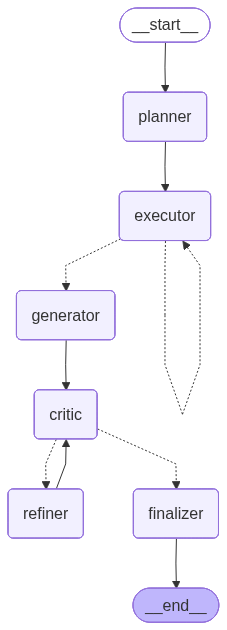

In [41]:
print("\nBuilding Plan-Execute-Reflect Hybrid Agent...")


hybrid_builder = StateGraph(PlanExecuteReflectState)

hybrid_builder.add_node("planner", planner)
hybrid_builder.add_node("executor", executor_with_timeout)
hybrid_builder.add_node("generator", generator)
hybrid_builder.add_node("critic", critic_with_timeout)
hybrid_builder.add_node("refiner", refiner_fast)
hybrid_builder.add_node("finalizer", finalizer)

hybrid_builder.add_edge(START, "planner")
hybrid_builder.add_edge("planner", "executor")

hybrid_builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {"executor": "executor", "generator": "generator"}
)

hybrid_builder.add_edge("generator", "critic")

hybrid_builder.add_conditional_edges(
    "critic",
    should_reflect_again,  
    {"refiner": "refiner", "finalizer": "finalizer"}  
)

hybrid_builder.add_edge("refiner", "critic") 
hybrid_builder.add_edge("finalizer", END)

hybrid_agent = hybrid_builder.compile()

print("Plan-Execute-Reflect Hybrid Agent created!")


graph_image = hybrid_agent.get_graph().draw_mermaid_png()
    
   
display(Image(graph_image))




In [43]:
print("\n" + "="*60)
print(" TEST: Running Simple Task")
print("="*60)

simple_task = "What are Python's main uses?"

print(f"\nTask: {simple_task}")

try:
    result = test_agent.invoke(
        {
            "input": simple_task,
            "plan": [],
            "current_step": 0,
            "step_results": [],
            "draft": "",
            "critique": "",
            "reflection_iterations": 0,
            "final_output": ""
        },
        config={"recursion_limit": 20}
    )
    
    print("\n" + "="*60)
    print(" AGENT EXECUTION SUCCESSFUL!")
    print("="*60)
    
    # Show summary
    print(f"\n EXECUTION SUMMARY:")
    print(f"  • Steps planned: {len(result.get('plan', []))}")
    print(f"  • Steps executed: {result.get('current_step', 0)}")
    print(f"  • Reflection cycles: {result.get('reflection_iterations', 0)}")
    print(f"  • Final output length: {len(result.get('final_output', ''))} chars")
    
    print(f"\n FINAL OUTPUT (first 300 chars):")
    print("="*40)
    final_output = result.get('final_output', '')
    print(final_output[:300] + "..." if len(final_output) > 300 else final_output)
    print("="*40)
    
except Exception as e:
    print(f"\n Agent execution failed: {e}")
    print("\n Trying manual step-by-step execution...")
    
    # Manual fallback
    state = {
        "input": simple_task,
        "plan": [],
        "current_step": 0,
        "step_results": [],
        "draft": "",
        "critique": "",
        "reflection_iterations": 0,
        "final_output": ""
    }
    
    print("\n1. Planning...")
    state.update(planner(state))
    
    print(f"\n2. Executing {len(state['plan'])} steps...")
    for i in range(len(state['plan'])):
        print(f"\n   Step {i+1}:")
        state.update(executor_with_timeout(state))
    
    print("\n3. Generating draft...")
    state.update(generator(state))
    
    print("\n4. Critiquing...")
    state.update(critic_with_timeout(state))
    
    print("\n5. Checking if refinement needed...")
    if should_reflect_again(state) == "refiner":
        print("  → Needs refinement")
        state.update(refiner_fast(state))
    else:
        print("  → No refinement needed")
    
    print("\n6. Finalizing...")
    state.update(finalizer(state))
    
    print("\n MANUAL EXECUTION COMPLETE!")
    print(f"\nFinal output ({len(state['final_output'])} chars):")
    print("-" * 40)
    print(state['final_output'][:400] + "..." if len(state['final_output']) > 400 else state['final_output'])


 TEST: Running Simple Task

Task: What are Python's main uses?

 CLEAN PLAN CREATED:
  1. Research the various applications of Python in different fields.
  2. Identify and categorize the main uses of Python, such as web development, data analysis, and automation.
  3. Compile examples and case studies that illustrate each use case.
  4. Summarize the findings in a clear and concise format.


 EXECUTING STEP 1: Research the various applications of Python in different fields.
 Used: search_internet
  Result: Python is versatile, easy to learn, has extensive libraries, great community support, and is used in...

 EXECUTING STEP 2: Identify and categorize the main uses of Python, such as web development, data analysis, and automation.
 Used: analyze_information
  Result: - Python is versatile and easy to learn.
- It has extensive libraries for various applications.
- Th...

 EXECUTING STEP 3: Compile examples and case studies that illustrate each use case.
 Used: LLM directly
  Result: P